# DATA 607 - Machine Learning

## Class 5 &mdash; 2025.05.03

### Dimension Reduction and Regularization

Small taste of multimodal embeddings: See [this colab notebook](https://colab.research.google.com/drive/1hm4M13xaOw1EteWZDfo_nShjFA44f5iO?usp=sharing).

In [357]:
import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedKFold,
)
from sklearn.linear_model import (
    Lasso,
    LogisticRegression,
    LinearRegression,
    Ridge,
)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [358]:
df = pd.read_csv(
    "data/auto_preprocessed.csv",
)

display(df)

X = df.copy()
y = X.pop("mpg")

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,is_european,is_japanese
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
385,36.0,4,135.0,84.0,2370,13.0,82,0,0
386,27.0,4,151.0,90.0,2950,17.3,82,0,0
387,27.0,4,140.0,86.0,2790,15.6,82,0,0
388,44.0,4,97.0,52.0,2130,24.6,82,1,0


- Including quadratic features improves CV-MSE over linear regression.

- Inluding cubic features severely degrades CV-MSE.

In [ ]:
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3],
}
model = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=100, random_state=42),
)

search.fit(X, y)
pd.DataFrame(search.cv_results_)[
    ["param_polynomialfeatures__degree", "mean_test_score", "rank_test_score"]
]

,param_polynomialfeatures__degree,mean_test_score,rank_test_score
0,1,-11.390829,2
1,2,-8.265291,1
2,3,-217.855856,3


In [362]:
PolynomialFeatures(degree=3).fit_transform(X).shape

(390, 165)

### Principal Component Analysis (PCA)

- Each row of the degree 3 `PolynomialFeatures` transform of `X` is 164-dimensnional.

- **Principal component analysis (PCA)** identifies optimal lower dimensional projections of these row vectors.

- Hopefully, what's lost in these projections is "noise".

- PCA operates only on the feature matrix `X`. The target vector `y` is not involved.

In [363]:
from sklearn.decomposition import PCA

model = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=3),
    StandardScaler(),
    PCA(n_components=45),
    LinearRegression(),
)

scores = cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=RepeatedKFold(n_repeats=100)
)
ic(scores.mean())

ic| scores.mean(): np.float64(-8.145599935185757)


np.float64(-8.145599935185757)

#### PCA for visualization

- PCA is often used to project high dimensional data into two dimensions to facilitate visualization.

##### ICMR Dataset

> The input dataset contains 802 samples for the corresponding 802 people who have been detected with different types of cancer. Each sample contains expression values of more than 20K genes. Samples have one of the types of tumours: BRCA, KIRC, COAD, LUAD, and PRAD.
>
> Source: [https://www.kaggle.com/datasets/shibumohapatra/icmr-data/data](https://www.kaggle.com/datasets/shibumohapatra/icmr-data/data)

In [365]:
X = pd.read_csv("~/Downloads/archive-3/data.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("~/Downloads/archive-3/labels.csv")["Class"]
display(X.head())

y.value_counts()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

In [366]:
y

0      PRAD
1      LUAD
2      PRAD
3      PRAD
4      BRCA
       ... 
796    BRCA
797    LUAD
798    COAD
799    PRAD
800    PRAD
Name: Class, Length: 801, dtype: object

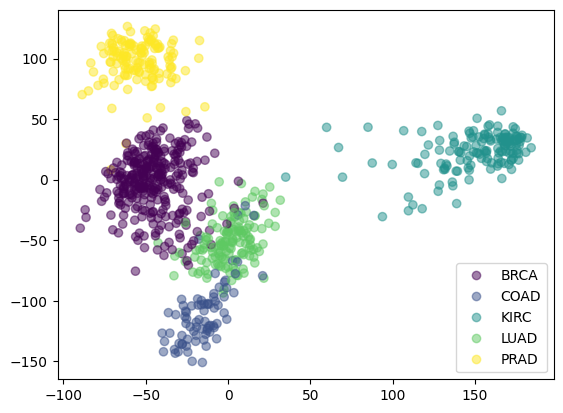

In [448]:
from sklearn.preprocessing import LabelEncoder

pca = PCA(n_components=2)
XX = pca.fit_transform(X)

label_encoder = LabelEncoder()
yy = label_encoder.fit_transform(y)

scatter = plt.scatter(XX[:, 0], XX[:, 1], c=yy, alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=list(label_encoder.classes_))
plt.show()

In [371]:
cross_val_score(LogisticRegression(), X, y, scoring="accuracy").mean()

np.float64(0.9975155279503106)

- The interest here is on inference &mdash; feature selection, in particular &mdash; not on prediction. We'll come back to this later today!

### Ridge regression

In [373]:
df = pd.read_csv(
    "data/auto_preprocessed.csv",
)

display(df)

X = df.copy()
y = X.pop("mpg")

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,is_european,is_japanese
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
385,36.0,4,135.0,84.0,2370,13.0,82,0,0
386,27.0,4,151.0,90.0,2950,17.3,82,0,0
387,27.0,4,140.0,86.0,2790,15.6,82,0,0
388,44.0,4,97.0,52.0,2130,24.6,82,1,0


In [132]:
for degree in range(1, 5):
    model = make_pipeline(
        PolynomialFeatures(include_bias=False, degree=degree),
        StandardScaler(),
        LinearRegression(),
    )
    model.fit(X, y)
    abs_coef_ = np.abs(model[-1].coef_)
    ic(degree, abs_coef_.std())

ic| degree: 1, abs_coef_.std(): np.float64(1.6779642591851287)
ic| degree: 2, abs_coef_.std(): np.float64(10.640951729534716)
ic| degree: 3, abs_coef_.std(): np.float64(362.2632631787211)
ic| degree: 4, abs_coef_.std(): np.float64(27100.321548837823)


- Implausibly large variation in effect sizes of standardized features indicative of overfitting.

### Model complexity

- The size of the coefficient vector $\beta$ is a reflection of linear model complexity. 

- There are many ways of measuring the size of a vector. For example:

  - square of squares:&nbsp; $\displaystyle\sum_i\beta_i^2$

  - sum of absolute values:&nbsp; $\displaystyle\sum_i|\beta_i|$

  - a weighted sum of these:&nbsp; $\displaystyle u \sum_i|\beta_i| + v \sum_i\beta_i^2$ where $u+v=1$

### Penalizing model complexity

- Write $\Omega(\beta)$ for any of the above size measures.

- Linear regression fits a model by minimizing the usual loss function given by sum of squared errors:
  $$
  \min_\beta \|y - X\beta\|^2
  $$

- Penalized variants of linear regression minimize penalized loss functions:
  $$
  \|y - X\beta\|^2 + \alpha\,\Omega(\beta)
  $$

  $\alpha$ is a tunable parameter.

### Ridge regression

- Penalized linear regression with $\Omega(\beta) = \text{sum of squared errors} = \sum_i\beta_i^2$.

- Use `sklearn.linear_model.Ridge`. Penalty `alpha` has default value `1`.

- Scale your features (e.g., `StandardScaler`) when using ridge regression!

#### Shrinkage

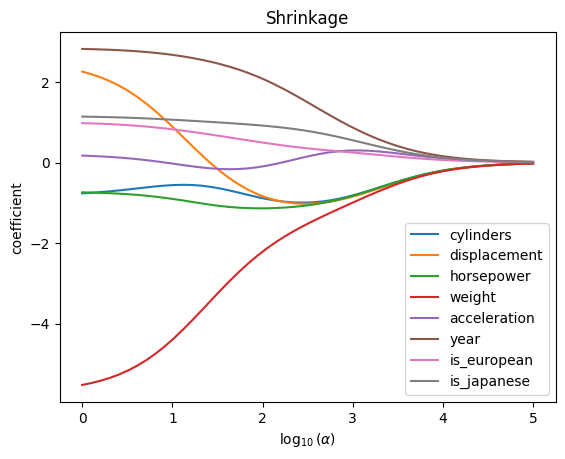

In [ ]:
alphas = np.logspace(0, 5, 50)

coefs = np.zeros((50, len(X.columns)))

for i, alpha in enumerate(alphas):
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(X, y)
    coefs[i] = model[-1].coef_

coefs = pd.DataFrame({c: np.array(coefs)[:, i] for i, c in enumerate(list(X.columns))})
coefs["logalpha"] = np.log10(alphas)

coefs.plot(x="logalpha")
plt.xlabel("$\\log_{10}(\\alpha)$")
plt.ylabel("coefficient")
plt.title("Shrinkage")
plt.show()

In [ ]:
param_grid = {
    "polynomialfeatures__degree": [2, 3, 4, 5],
    "ridge__alpha": np.logspace(-2, 1.5, 50),
}

model = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), Ridge())

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=100, random_state=42),
)

search.fit(X, y)

ic(search.best_params_)
ic(-search.best_score_)

ic| search.best_params_: {'polynomialfeatures__degree': 3,
                          'ridge__alpha': np.float64(0.08483428982440717)}
ic| -search.best_score_: np.float64(7.5021598350501995)


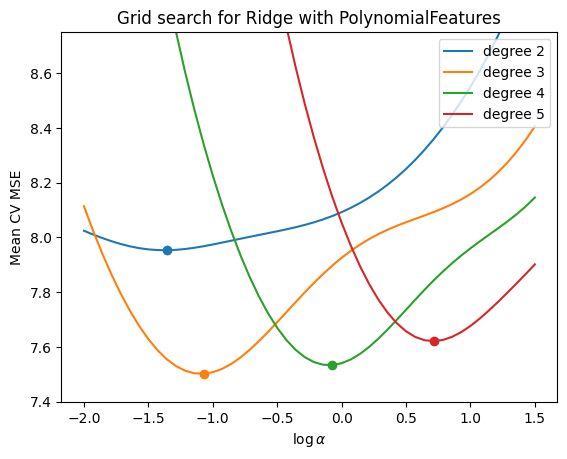

In [60]:
results = pd.DataFrame(search.cv_results_)
for degree, group in results.groupby("param_polynomialfeatures__degree"):
    logalpha = np.log10(group["param_ridge__alpha"].to_numpy())
    meanmse = -group["mean_test_score"].to_numpy()
    j = meanmse.argmin()
    plt.plot(logalpha, meanmse, label=f"degree {degree}")
    plt.plot(logalpha[j], meanmse[j], "o", color=f"C{degree - 2}")

plt.legend(loc="upper right")
plt.ylim(7.4, 8.75)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("Mean CV MSE")
plt.title("Grid search for Ridge with PolynomialFeatures")

plt.show()

### The LASSO

"Least Absolute Selection and Shrinkage Operator"

In [ ]:
from sklearn.model_selection import KFold

model = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2),
    StandardScaler(),
    Lasso(alpha=1e-3, max_iter=1000000),
)

cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=KFold(shuffle=True)
).mean()

np.float64(-8.476415257334624)

In [ ]:
param_grid = {
    "polynomialfeatures__degree": [2],
    "lasso__alpha": np.logspace(-3.5, -2.5, 10),
}

model = make_pipeline(
    PolynomialFeatures(include_bias=False), StandardScaler(), Lasso(max_iter=1000000)
)

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=10),
    verbose=True,
)

search.fit(X, y)

ic(search.best_params_)
ic(-search.best_score_)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


ic| search.best_params_: {'lasso__alpha': np.float64(0.0014677992676220691),
                          'polynomialfeatures__degree': 2}
ic| -search.best_score_: np.float64(8.011041311330752)


np.float64(8.011041311330752)

Text(0, 0.5, 'mean test score')

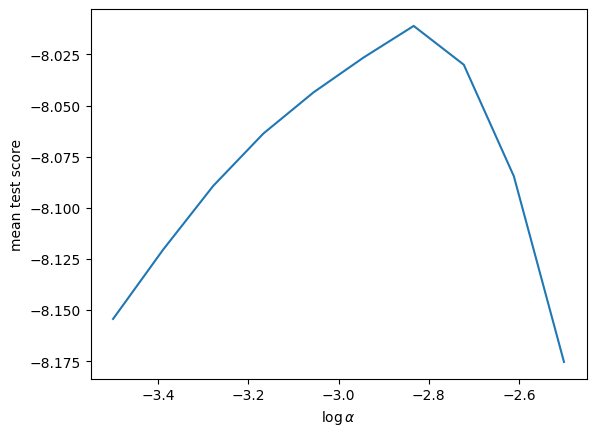

In [280]:
plt.plot(
    np.log10(search.cv_results_["param_lasso__alpha"]),
    search.cv_results_["mean_test_score"],
)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("mean test score")

In [1]:
from sklearn.linear_model import lasso_path

preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-5, -1, 1000), max_iter=100000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", lw=0.5)

best_alpha = search.best_params_["lasso__alpha"]
plt.plot([np.log10(best_alpha), np.log10(best_alpha)], plt.ylim(), "k--")

plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

NameError: name 'make_pipeline' is not defined

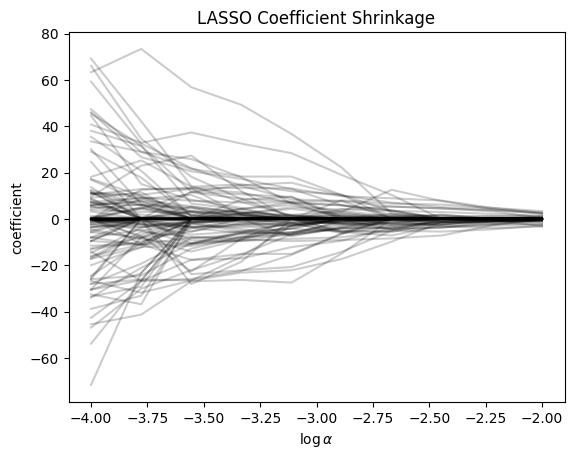

In [290]:
preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=3), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-4, -2, 10), max_iter=10000000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", alpha=0.2)


plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

##### Back to the ICMR dataset

In [419]:
X = pd.read_csv("~/Downloads/archive-3/data.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("~/Downloads/archive-3/labels.csv")["Class"]

cross_val_score(
    LogisticRegression(penalty="l1", solver="liblinear", C=0.01),
    X,
    y,
    scoring="accuracy",
).mean()

np.float64(1.0)

In [432]:
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X, y)
np.sum(~np.isclose(model.coef_, 0))

np.int64(181)

In [433]:
set(model.coef_[0].nonzero()[0]).intersection(set(model.coef_[1].nonzero()[0]))

set()

In [446]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_0 = list(zip(*model.coef_.nonzero()))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_1 = list(zip(*model.coef_.nonzero()))

In [ ]:
len(set(indices_0)), len(set(indices_1)), len(
    set(indices_0).intersection(set(indices_1))
)

(167, 160, 105)